In [45]:
#cell code 1
import os
import logging
from typing import List, Literal, Optional
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_neo4j.vectorstores.neo4j_vector import Neo4jVector
from langchain_neo4j.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_neo4j import Neo4jGraph
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from langchain_neo4j.chains.graph_qa.cypher import GraphCypherQAChain
from IPython.display import Image, display
from langgraph.graph import StateGraph, END, add_messages
from typing_extensions import TypedDict, Annotated

In [46]:
#cell code 2

# --- Environment Variables ---
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

# Neo4J Local
neo4j_uri = os.environ.get("NEO4J_URI")
neo4j_username = os.environ.get("NEO4J_USERNAME")
neo4j_password = os.environ.get("NEO4J_PASSWORD_ICS")

#Langchain
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-Agent CyKG" 
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY", "")
os.environ["LANGCHAIN_ENDPOINT"] = os.environ.get("LANGCHAIN_ENDPOINT", "")

# --- Logging Config ---
logging.basicConfig(
     level=logging.INFO,
     format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
     handlers=[
         logging.FileHandler('./log/multi_agent_cykg.log'),
         logging.StreamHandler()
     ]
)
logger = logging.getLogger(__name__)

In [47]:
#cell code 3
# --- LLM and Graph Connections ---
graph = Neo4jGraph(
    url=neo4j_uri,
    username=neo4j_username,
    password=neo4j_password
)
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

# --- Global Configs & Schema ---
DEFAULT_MAX_ITERATIONS = 3
NEO4J_SCHEMA_RAW = graph.schema
NEO4J_SCHEMA_ESCAPED_FOR_PROMPT = NEO4J_SCHEMA_RAW.replace("{", "{{").replace("}", "}}")

In [49]:
#cell code 4
class AgentState(TypedDict):
    question: str
    original_question: str
    is_relevant: bool
    vector_context: Optional[str]
    cypher_context: Optional[List[dict]]
    answer: Optional[str]
    cypher_query: Optional[str]
    error: Optional[str]
    messages: Annotated[list, add_messages]
    
    # reflection state
    cypher_iteration_count: int
    vector_iteration_count: int
    vector_answer_sufficient: bool 
    cypher_answer_sufficient: bool 
    
    max_iterations: int

In [50]:
#cell code 5

# --- Tools & Chains for Guardrails ---
class GuardrailsOutput(BaseModel):
    decision: Literal["relevant", "irrelevant"] = Field(description="Is the question relevant to cybersecurity, MITRE ATT&CK, tactics, malware, or threat actors?")

guardrails_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a gatekeeper for a cybersecurity Q&A system. Your task is to determine if a user's question is related to cybersecurity topics like MITRE ATT&CK, attack techniques, malware, threat groups, or mitigations. Only allow relevant questions to pass."),
    ("human", "Question: {question}"),
])
guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)

# --- Node Definition: Guardrails ---
def guardrails_node(state: AgentState):
    """Decides if the question is relevant."""
    logger.info("--- Executing Node: [[Guardrails]] ---")
    question = state['question']
    result = guardrails_chain.invoke({"question": question})
    if result.decision == "irrelevant":
        logger.warning(f"[[Guardrails]]: Irrelevant question detected -> '{question}'")
        return {"is_relevant": False, "answer": "Sorry, I can only answer questions related to cybersecurity and MITRE ATT&CK."}
    else:
        logger.info("[[Guardrails]]: Question is relevant.")
        return {"is_relevant": True}

In [51]:
#cell code 6

# --- Vector Index Initialization ---
vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    url=neo4j_uri,
    username=neo4j_username,
    password=neo4j_password,
    search_type="hybrid",
    node_label="Resource",
    text_node_properties=["ns1__description"],
    embedding_node_property="embedding"
)

2025-07-28 17:29:12,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [52]:
#cell code 7

# --- Chains for Vector Search (Entity Extraction) ---
class Entities(BaseModel):
    """Identifying information about resources."""

    names: List[str] = Field(
        ...,
        description="All the tactics, techniques, or software entities that "
        "appear in the text",
    )
    
entity_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting attack techniques, tactics, malware, mitigations entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = entity_prompt | llm.with_structured_output(Entities) #Pokoknya buat entity extraction

In [53]:
#cell code 8

# --- Helper Functions for Vector Search ---
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of resources mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node, score
            
            MATCH (node)-[r]-(neighbor)
            WHERE node.ns1__title IS NOT NULL AND neighbor.ns1__title IS NOT NULL
            
            RETURN CASE
                WHEN startNode(r) = node 
                THEN node.ns1__title + ' - ' + type(r) + ' -> ' + neighbor.ns1__title
                ELSE neighbor.ns1__title + ' - ' + type(r) + ' -> ' + node.ns1__title
            END AS output
            LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result

def query_vector_search(question: str):
    """
    Query the graph and vector index using a vector approach for vector similarity search.
    Use this for questions that require finding similar concepts or descriptions,
    like "Show me techniques related to 'SQL Injection'".
    """
    print(f"--- Executing Vector Search for: {question} ---")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
    {structured_data}
    Unstructured data:
    {"#Resource ". join(unstructured_data)}
    """
    return final_data


# --- Node Definition: Vector Agent ---
def vector_search_node(state: AgentState):
    """Calls the vector search tool and populates the state."""
    logger.info("--- Executing Node: [[vector_agent]] ---")
    question = state['question']
    try:
        vector_context = query_vector_search(question)
        logger.info("[[Vector Agent]] : Vector search completed successfully.")
        logger.info(f"[[Vector Agent]] : Vector search context found:\n{vector_context}")
        return {"vector_context": vector_context}
    except Exception as e:
        logger.error(f"[[Vector Agent]] : Vector search failed: {e}")
        return {"vector_context": f"Error during vector search: {e}"}

In [54]:
#cell code 9

# --- Tools & Chains for Reviewing Answers ---
class ReviewOutput(BaseModel):
    """Decision model for reviewing the sufficiency of an answer."""
    decision: Literal["sufficient", "insufficient"] = Field(description="Is the provided context sufficient to answer the user's question?")
    reasoning: str = Field(description="A brief explanation for the decision.")

review_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert in evaluating the quality of retrieved information. Your task is to determine if the provided 'Context' is sufficient to fully answer the 'Original Question'. Do not try to answer the question yourself, only evaluate the context."),
    ("human", "Original Question: {question}\n\nContext:\n{context}\n\nBased on the context, is it sufficient to answer the question?"),
])
review_chain = review_prompt | llm.with_structured_output(ReviewOutput)

# --- Node Definition: Review Vector Answer ---
def review_vector_node(state: AgentState):
    """Reviews the context from the vector search."""
    logger.info("--- Executing Node: [[review_vector_answer]] ---")
    question = state['original_question']
    context = state['vector_context']
    
    if not context or "Error during vector search" in context:
        logger.warning("[[Review Vector]]: Context is empty or contains an error. Marking as insufficient.")
        return {"vector_answer_sufficient": False}

    review = review_chain.invoke({"question": question, "context": context})
    logger.info(f"[[Review Vector]]: Decision: {review.decision}. Reasoning: {review.reasoning}")
    
    return {"vector_answer_sufficient": review.decision == "sufficient"}

# --- Node Definition: Review Cypher Answer ---
def review_cypher_node(state: AgentState):
    """Reviews the context from the cypher search."""
    logger.info("--- Executing Node: [[review_cypher_answer]] ---")
    question = state['original_question']
    context = str(state['cypher_context'])

    if not state.get('cypher_context'):
        logger.warning("[[Review Cypher]]: Context is empty. Marking as insufficient.")
        return {"cypher_answer_sufficient": False}
        
    review = review_chain.invoke({"question": question, "context": context})
    logger.info(f"[[Review Cypher]]: Decision: {review.decision}. Reasoning: {review.reasoning}")

    return {"cypher_answer_sufficient": review.decision == "sufficient"}

In [55]:
#cell code 10

# --- Cypher Generation Prompt Template ---
cypher_generation_template = """
You are an expert Neo4j Cypher translator who converts English to Cypher based on the Neo4j Schema provided, following the instructions below:
        1. Generate Cypher query compatible ONLY for Neo4j Version 5
        2. Do not use EXISTS, SIZE, HAVING keywords in the cypher. Use alias when using the WITH keyword
        3. Use only Nodes and relationships mentioned in the schema
        5. Never use relationships that are not mentioned in the given schema
        6. For all node labels and relationship types, add namespace prefix `ns0__` before the actual label or relationship type. E.g., `MATCH (n:ns0__NodeLabel)-[:ns0__RelationshipType]->(m:ns0__NodeLabel)`.
        7. Node properties with `created`, `description`, `identifier`, `modified`, `title` and `version`, add prefix `ns1__` instead. E.g., `MATCH (n:ns0__NodeLabel) RETURN n.ns1__title AS Title`.
        8. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Tactic, use `toLower(Tactic.ns1__title) contains 'persistence'`.
        9. Always assign a meaningful name to every node and relationship in the MATCH clause
        10. Never return components not explicitly named in the MATCH clause.
        11. In the RETURN clause, include all named components (nodes, relationships, or properties) to ensure consistency and understanding.
        12. Always return all the nodes used in the MATCH clause to provide complete information to the user.
        13. When counting distinct items that come from an `OPTIONAL MATCH`, prefer to `collect()` them first and then use `size()` on the collected list to avoid warnings about null values. For example, instead of `count(DISTINCT optional_item)`, use `WITH main_node, collect(DISTINCT optional_item) AS items` and then in the `RETURN` clause use `size(items) AS itemCount`.
        14. To create unique pairs of nodes for comparison (e.g., for similarity calculations), use the `elementId()` function instead of the deprecated `id()` function. For example: `WHERE elementId(node1) < elementId(node2)`.
        15. use `toLower()` function to ensure case-insensitive comparisons for string properties.

Schema:
{schema}

Note: 
Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything other than
for you to construct a Cypher statement. Do not include any text except
the generated Cypher statement. Make sure the direction of the relationship is
correct in your queries. Make sure you alias both entities and relationships
properly. Do not run any queries that would add to or delete from
the database. Make sure to alias all statements that follow as with
statement

In Cypher, you can alias nodes and relationships, but not entire pattern matches using AS directly after a MATCH clause.If you want to alias entire patterns or results of more complex expressions, that should be done in the RETURN clause, not the MATCH clause.
If you want to include any specific properties from these nodes in your results, you can add them to your RETURN statement.

Examples : 

1. Which techniques are commonly used by at least 3 different threat groups?
MATCH (g:ns0__Group)-[:ns0__usesTechnique]->(t:ns0__Technique)
WITH t, count(g) as groupCount
WHERE groupCount >= 3
MATCH (g:ns0__Group)-[:ns0__usesTechnique]->(t)
RETURN t.ns1__title as CommonTechnique, t.ns1__identifier as TechniqueID, 
       groupCount as NumberOfGroups,
       collect(g.ns1__title) as Groups
ORDER BY groupCount DESC

2. Find tactical areas where we have the most significant defensive gaps by identifying tactics that have many techniques but few mitigations, and rank them by coverage percentage!

MATCH (tactic:ns0__Tactic)<-[:ns0__accomplishesTactic]-(technique:ns0__Technique)
WITH tactic, collect(technique) as techniques, count(technique) as techniqueCount
UNWIND techniques as technique
OPTIONAL MATCH (mitigation:ns0__Mitigation)-[:ns0__preventsTechnique]->(technique)
WITH tactic, techniqueCount, technique, count(mitigation) > 0 as hasMitigation

WITH tactic, techniqueCount, 
     sum(CASE WHEN hasMitigation THEN 1 ELSE 0 END) as mitigatedTechniques,
     collect(CASE WHEN NOT hasMitigation THEN technique.ns1__title ELSE NULL END) as unmitigatedTechniques

WITH tactic, techniqueCount, mitigatedTechniques,
     [x IN unmitigatedTechniques WHERE x IS NOT NULL] as filteredUnmitigatedTechniques,
     (toFloat(mitigatedTechniques) / techniqueCount * 100) as coveragePercentage

RETURN tactic.ns1__title as Tactic,
       tactic.ns1__identifier as TacticID,
       techniqueCount as TotalTechniques,
       mitigatedTechniques as MitigatedTechniques,
       techniqueCount - mitigatedTechniques as UnmitigatedTechniqueCount,
       toInteger(coveragePercentage) as CoveragePercentage,
       CASE 
         WHEN coveragePercentage < 30 THEN "CRITICAL" 
         WHEN coveragePercentage < 60 THEN "HIGH" 
         WHEN coveragePercentage < 80 THEN "MEDIUM"
         ELSE "LOW"
       END as RiskLevel,
       filteredUnmitigatedTechniques as UnmitigatedTechniques
ORDER BY coveragePercentage ASC, techniqueCount DESC


The question is:
{question}

"""

cyper_generation_prompt = PromptTemplate(
    template=cypher_generation_template,
    input_variables=["schema","question"]
)

In [56]:
#cell code 11

# --- Cypher QA Prompt Template ---
qa_template = """
You are an assistant that takes the results from a Neo4j Cypher query and forms a human-readable response. The query results section contains the results of a Cypher query that was generated based on a user's natural language question. The provided information is authoritative; you must never question it or use your internal knowledge to alter it. Make the answer sound like a response to the question.
Final answer should be easily readable and structured.
Query Results:
{context}

Question: {question}
If the provided information is empty, respond by stating that you don't know the answer. Empty information is indicated by: []
If the information is not empty, you must provide an answer using the results. If the question involves a time duration, assume the query results are in units of days unless specified otherwise.
Never state that you lack sufficient information if data is present in the query results. Always utilize the data provided.
Helpful Answer:
"""

qa_generation_prompt = PromptTemplate(
    template=qa_template,
    input_variables=["context", "question"]
)

In [57]:
#cell code 12

# --- Cypher QA Chain and Query Function ---
cypher_qa_chain = GraphCypherQAChain.from_llm(
    top_k=10,
    graph=graph,
    verbose=True,
    validate_cypher=True,
    return_intermediate_steps=True,
    cypher_prompt=cyper_generation_prompt,
    qa_prompt=qa_generation_prompt,
    qa_llm=ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
    cypher_llm=ChatOpenAI(model="gpt-4o", temperature=0),
    allow_dangerous_requests=True,
    use_function_response=True
)

def query_cypher(question: str) -> dict:
    """
    Generate and run a Cypher query against the graph database.
    Use this for complex questions requiring structured data, aggregations, or specific graph traversals
    Returns the query and the result context.
    """
    print(f"--- Executing Cypher Search for: {question} ---")
    response = cypher_qa_chain.invoke({"query": question})
    return {
        "query": response["intermediate_steps"][0]["query"],
        "context": response["intermediate_steps"][1]["context"]
    }

# --- Node Definition: Cypher Agent ---
def cypher_query_node(state: AgentState):
    """Calls the cypher search tool and populates the state."""
    logger.info(f"--- Executing Node: [[cypher_agent]] (Attempt: {state.get('iteration_count', 1)}) ---")
    question = state['question']
    try:
        cypher_result = query_cypher(question)
        context = cypher_result.get("context", [])
        generated_query = cypher_result.get("query", "")

        if not context:
            logger.warning(f"[[Cypher Agent]]: No results found for query: {generated_query}")
        else:
            logger.info(f"[[Cypher Agent]]: Found context. Query: {generated_query}")

        return {
            "cypher_query": generated_query,
            "cypher_context": context
        }
    except Exception as e:
        logger.error(f"[[Cypher Agent]] failed: {e}", exc_info=True)
        return {
            "error": f"Query Cypher failed: {e}",
            "cypher_context": [],
            "cypher_query": "Failed to generate Cypher query due to an error."
        }

In [58]:
#cell code 13

# --- Chains for Cypher Reflection ---
class RephrasedQuestion(BaseModel):
    rephrased_question: str = Field(description="A rephrased, more specific version of the original question to improve Cypher query generation.")

cypher_reflection_prompt = ChatPromptTemplate.from_messages([
    ("system", f"""You are a query correction expert. A Cypher query returned no results.
Your task is to rephrase the user's question to be more specific and likely to succeed with the given Neo4j graph schema.
Analyze the failed query and the schema. For example, if the question was too broad, make it more specific. If it used terms not in the schema, suggest alternatives.
Do not just repeat the question. Provide a meaningful improvement.

Schema:
{NEO4J_SCHEMA_ESCAPED_FOR_PROMPT}"""),
    ("human", "Original Question: {original_question}\n\nFailed Cypher Query:\n{cypher_query}\n\nRephrase the question to improve the chances of getting a result."),
])
reflection_chain = cypher_reflection_prompt | llm.with_structured_output(RephrasedQuestion)

# --- Node Definition: Cypher Reflection ---
def cypher_reflection_node(state: AgentState):
    """Reflects on the failed cypher query and rephrases the question."""
    logger.info("--- Executing Node: [[cypher_reflection]] ---") 
    original_question = state['original_question']
    failed_query = state['cypher_query']
    
    rephrased_result = reflection_chain.invoke({
        "original_question": original_question,
        "cypher_query": failed_query
    })
    
    new_question = rephrased_result.rephrased_question
    iteration_count = state['cypher_iteration_count'] + 1
    logger.info(f"[[Cypher Reflection]]: Rephrasing question to: '{new_question}'. New attempt: {iteration_count}.")
    
    return {"question": new_question, "cypher_iteration_count": iteration_count}

In [59]:
#cell code 14 (Baru)

# --- Tools & Chains for Vector Reflection ---
class RephrasedQuestion(BaseModel):
    rephrased_question: str = Field(description="A rephrased, more specific version of the original question to improve search results.")

vector_reflection_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a query correction expert. A vector search returned insufficient or irrelevant context.
Your task is to rephrase the user's question to be more specific and likely to succeed with a vector/keyword search.
Analyze the original question and the insufficient context. For example, if the question was too broad, suggest adding specific keywords. If it used ambiguous terms, make them clearer.
Do not just repeat the question. Provide a meaningful improvement.
"""),
    ("human", "Original Question: {original_question}\n\nInsufficient Context from Vector Search:\n{vector_context}\n\nRephrase the question to improve the chances of getting a better result."),
])
vector_reflection_chain = vector_reflection_prompt | llm.with_structured_output(RephrasedQuestion)

# --- Node Definition: Vector Reflection ---
def vector_reflection_node(state: AgentState):
    """Reflects on the failed vector search and rephrases the question."""
    logger.info("--- Executing Node: [[vector_reflection]] ---")
    original_question = state['original_question']
    insufficient_context = state['vector_context']
    
    rephrased_result = vector_reflection_chain.invoke({
        "original_question": original_question,
        "vector_context": insufficient_context
    })
    
    new_question = rephrased_result.rephrased_question
    iteration_count = state['vector_iteration_count'] + 1
    logger.info(f"[[Vector Reflection]]: Rephrasing question to: '{new_question}'. New attempt: {iteration_count}.")
    
    return {"question": new_question, "vector_iteration_count": iteration_count}

In [69]:
#cell code 15

# --- Synthesis Prompt and Chain ---
synthesis_prompt = ChatPromptTemplate.from_template("""You are an expert cybersecurity analyst. Your task is to synthesize information from multiple sources to create a comprehensive report that answers the user's question.

The final output MUST follow this exact structure, including the markdown for bolding and formatting. Do not add any text outside of this structure.

**Key Findings from Each Source:**

1.  **Context from Cypher Query:**
    [Summarize the key findings from the Cypher context here. If the context is empty, null, or contains 'No data', state that "No data was provided from this source."]

2.  **Context from Vector Search:**
    [Summarize the key findings from the Vector context here. You can break this down into "Structured Data" and "Unstructured Data" if the context allows. If the context is empty, null, or contains 'No data', state that "No data was provided from this source."]

**Critical Analysis:**

[Provide a critical analysis of how the combined information answers the "Original Question". If one source is empty, analyze the sufficiency of the information from the other source. Explain whether the information is comprehensive or if there are any gaps.]

**Final Answer:**

[Based on your analysis, construct a final, well-structured, human-readable answer for the user. Synthesize the findings into a cohesive response.]

---
Here is the data to use for generating the report:

**Original Question:** {question}

**Context from Cypher Query:**
{cypher_context}

**Context from Vector Search:**
{vector_context}
""")

synthesis_chain = synthesis_prompt | llm | StrOutputParser()

# --- Node Definition: Synthesizer ---
def synthesize_node(state: AgentState):
    """Generates the final compiled answer for the user based on all gathered context."""
    logger.info("--- Executing Node: [[synthesizer]] ---")
    
    # Check if any context exists at all after all retries
    if not state.get('vector_context') and not state.get('cypher_context'):
        final_answer = "Sorry, after several attempts, I could not find any information related to your question from any of our data sources."
    else:
        logger.info("[[Synthesizer]]: Compiling final answer from available context.")
        final_answer = synthesis_chain.invoke({
            "question": state['original_question'],
            "cypher_context": str(state.get('cypher_context', 'No data was provided from this source.')),
            "vector_context": str(state.get('vector_context', 'No data was provided from this source.'))
        })
        
    return {"answer": final_answer}

In [70]:
#cell code 16

# --- Workflow Assembly ---
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("guardrails", guardrails_node)
workflow.add_node("vector_agent", vector_search_node)
workflow.add_node("review_vector_answer", review_vector_node)
workflow.add_node("vector_reflection", vector_reflection_node)
workflow.add_node("cypher_agent", cypher_query_node)
workflow.add_node("review_cypher_answer", review_cypher_node)
workflow.add_node("cypher_reflection", cypher_reflection_node)
workflow.add_node("synthesizer", synthesize_node)


# --- Define Edges ---
workflow.set_entry_point("guardrails")

# 1. Decision after Guardrails
def decide_relevance(state: AgentState):
    if state.get('is_relevant'):
        logger.info("[Decision] Question is relevant, proceeding to search.")
        return "vector_agent"
    else:
        logger.info("[Decision] Question is irrelevant, ending execution.")
        return END


# 2. Decision after Vector Review
def decide_after_vector_review(state: AgentState):
    if state.get('vector_answer_sufficient'):
        logger.info("[Decision] Vector context is sufficient. Proceeding to Cypher agent.")
        return "cypher_agent"
    if state.get("vector_iteration_count", 0) < state.get("max_iterations", 3):
        logger.warning("[Decision] Vector context is insufficient. Proceeding to reflection.")
        return "vector_reflection"
    else:
        logger.error("[Decision] Max retries for Vector search reached. Proceeding to Cypher agent.")
        return "cypher_agent"
    

# 3. Decision after Cypher Review
def decide_after_cypher_review(state: AgentState):
    if state.get('cypher_answer_sufficient'):
        logger.info("[Decision] Cypher context is sufficient. Proceeding to synthesizer.")
        return "synthesizer"
    if state.get("cypher_iteration_count", 0) < state.get("max_iterations", 3):
        logger.warning("[Decision] Cypher context is insufficient. Proceeding to reflection.")
        return "cypher_reflection"
    else:
        logger.error("[Decision] Max retries for Cypher reached. Proceeding to synthesizer.")
        return "synthesizer"
    
# Add Edges to the graph
workflow.add_conditional_edges(
    "guardrails", 
    decide_relevance, 
    {
        "vector_agent": "vector_agent", 
        END: END
    }
)

workflow.add_edge(
    "vector_agent",
    "review_vector_answer"

)
workflow.add_conditional_edges(
    "review_vector_answer", 
    decide_after_vector_review, 
    {
        "cypher_agent": "cypher_agent", 
        "vector_reflection": "vector_reflection"
    }
)

workflow.add_edge(
    "vector_reflection",
    "vector_agent"
)

workflow.add_edge(
    "cypher_agent",
    "review_cypher_answer"
)

workflow.add_conditional_edges(
    "review_cypher_answer",
    decide_after_cypher_review,
    {
        "synthesizer": "synthesizer",
        "cypher_reflection": "cypher_reflection"
    }
)

workflow.add_edge(
    "cypher_reflection", 
    "cypher_agent"
)

workflow.add_edge(
    "synthesizer", 
    END
)

# Compile graph
app = workflow.compile()

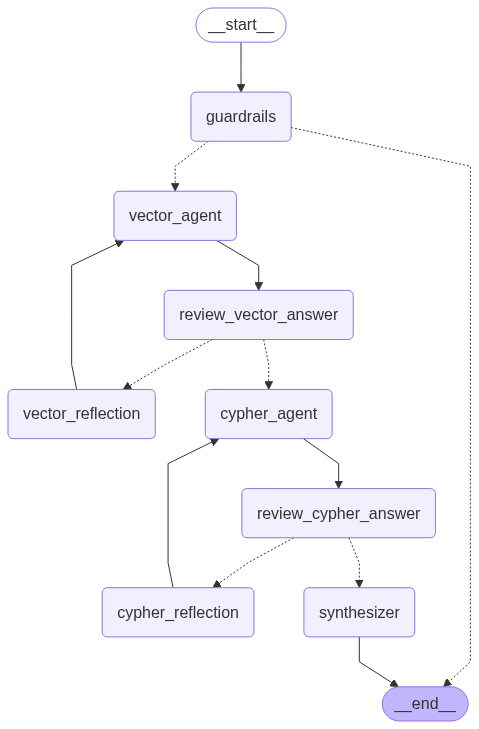

In [71]:
#cell code 17

# --- Visualize the Graph ---
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not create graph visualization: {e}")

In [72]:
#cell code 18

# --- Invocation ---
query1 = "Which MITRE ATT&CK techniques are used by attackers to escalate their privileges within a network?"
query2 = "find me a list of mitigation actions for attack technique Credential Access"

# Irrelevant question for Guardrails example
query3 = "What is the best recipe for fried chicken?"

initial_state = {
    "question": query2,
    "original_question": query2,
    "messages": [("human", query2)],
    "cypher_iteration_count": 1,
    "vector_iteration_count": 1,
    "max_iterations": 3,
}

config = {"recursion_limit": 30}
final_result = app.invoke(initial_state, config=config)


2025-07-28 17:48:42,969 - __main__ - INFO - --- Executing Node: [[Guardrails]] ---
2025-07-28 17:48:44,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-28 17:48:44,091 - __main__ - INFO - [[Guardrails]]: Question is relevant.
2025-07-28 17:48:44,092 - __main__ - INFO - [Decision] Question is relevant, proceeding to search.
2025-07-28 17:48:44,093 - __main__ - INFO - --- Executing Node: [[vector_agent]] ---


--- Executing Vector Search for: find me a list of mitigation actions for attack technique Credential Access ---


2025-07-28 17:48:45,023 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-28 17:48:45,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-28 17:48:45,760 - __main__ - INFO - [[Vector Agent]] : Vector search completed successfully.
2025-07-28 17:48:45,760 - __main__ - INFO - [[Vector Agent]] : Vector search context found:
Structured data:
    
    Unstructured data:
    
ns1__description: The full ATT&CK for ICS Matrix includes techniques spanning various ICS assets and can be used to navigate through the knowledge base.#Resource 
ns1__description: Adversaries may modify software and device credentials to prevent operator and responder access. Depending on the device, the modification or addition of this password could prevent any device configuration actions from being accomplished and may require a factory reset or replacement of hardware. These credentials are often built-in feat

--- Executing Vector Search for: What are specific mitigation strategies for the Credential Access technique in cybersecurity, particularly within the MITRE ATT&CK framework? ---


2025-07-28 17:48:51,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-28 17:48:52,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-07-28 17:48:52,071 - __main__ - INFO - [[Vector Agent]] : Vector search completed successfully.
2025-07-28 17:48:52,072 - __main__ - INFO - [[Vector Agent]] : Vector search context found:
Structured data:
    
    Unstructured data:
    
ns1__description: Require user authentication before allowing access to data or accepting commands to a device. While strong multi-factor authentication is preferable, it is not always feasible within ICS environments. Performing strong user authentication also requires additional security controls and processes which are often the target of related adversarial techniques (e.g., Valid Accounts, Default Credentials). Therefore, associated ATT&CK mitigations should be considered in addition to this, including [Multi-f

--- Executing Cypher Search for: What are specific mitigation strategies for the Credential Access technique in cybersecurity, particularly within the MITRE ATT&CK framework? ---


> Entering new GraphCypherQAChain chain...


2025-07-28 17:48:57,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated Cypher:
cypher
MATCH (technique:ns0__Technique)
WHERE toLower(technique.ns1__title) CONTAINS 'credential access'
OPTIONAL MATCH (technique)-[r:ns0__hasMitigation]->(mitigation:ns0__Mitigation)
WITH technique, collect(mitigation) AS mitigations
RETURN technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID, 
       [m IN mitigations | m.ns1__title] AS MitigationStrategies

Full Context:
[]


2025-07-28 17:48:58,641 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-28 17:48:58,645 - __main__ - WARNING - [[Cypher Agent]]: No results found for query: cypher
MATCH (technique:ns0__Technique)
WHERE toLower(technique.ns1__title) CONTAINS 'credential access'
OPTIONAL MATCH (technique)-[r:ns0__hasMitigation]->(mitigation:ns0__Mitigation)
WITH technique, collect(mitigation) AS mitigations
RETURN technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID, 
       [m IN mitigations | m.ns1__title] AS MitigationStrategies

2025-07-28 17:48:58,646 - __main__ - INFO - --- Executing Node: [[review_cypher_answer]] ---
2025-07-28 17:48:58,646 - __main__ - WARNING - [[Review Cypher]]: Context is empty. Marking as insufficient.
2025-07-28 17:48:58,647 - __main__ - WARNING - [Decision] Cypher context is insufficient. Proceeding to reflection.
2025-07-28 17:48:58,648 - __main__ - INFO - --- Executing Node: [[cy


> Finished chain.


2025-07-28 17:49:00,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-28 17:49:00,092 - __main__ - INFO - [[Cypher Reflection]]: Rephrasing question to: 'What are the mitigation actions associated with the specific attack technique titled 'Credential Dumping'?'. New attempt: 2.
2025-07-28 17:49:00,093 - __main__ - INFO - --- Executing Node: [[cypher_agent]] (Attempt: 1) ---


--- Executing Cypher Search for: What are the mitigation actions associated with the specific attack technique titled 'Credential Dumping'? ---


> Entering new GraphCypherQAChain chain...


2025-07-28 17:49:02,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated Cypher:
cypher
MATCH (technique:ns0__Technique)
WHERE toLower(technique.ns1__title) CONTAINS 'credential dumping'
MATCH (technique)-[rel:ns0__hasMitigation]->(mitigation:ns0__Mitigation)
RETURN technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID, 
       mitigation.ns1__title AS MitigationTitle, 
       mitigation.ns1__identifier AS MitigationID

Full Context:
[]


2025-07-28 17:49:03,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-28 17:49:03,379 - __main__ - WARNING - [[Cypher Agent]]: No results found for query: cypher
MATCH (technique:ns0__Technique)
WHERE toLower(technique.ns1__title) CONTAINS 'credential dumping'
MATCH (technique)-[rel:ns0__hasMitigation]->(mitigation:ns0__Mitigation)
RETURN technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID, 
       mitigation.ns1__title AS MitigationTitle, 
       mitigation.ns1__identifier AS MitigationID

2025-07-28 17:49:03,380 - __main__ - INFO - --- Executing Node: [[review_cypher_answer]] ---
2025-07-28 17:49:03,381 - __main__ - WARNING - [[Review Cypher]]: Context is empty. Marking as insufficient.
2025-07-28 17:49:03,381 - __main__ - WARNING - [Decision] Cypher context is insufficient. Proceeding to reflection.
2025-07-28 17:49:03,382 - __main__ - INFO - --- Executing Node: [[cypher_reflection]] ---



> Finished chain.


2025-07-28 17:49:04,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-28 17:49:04,977 - __main__ - INFO - [[Cypher Reflection]]: Rephrasing question to: 'What are the mitigation actions associated with the specific attack technique titled 'Credential Dumping'?'. New attempt: 3.
2025-07-28 17:49:04,979 - __main__ - INFO - --- Executing Node: [[cypher_agent]] (Attempt: 1) ---


--- Executing Cypher Search for: What are the mitigation actions associated with the specific attack technique titled 'Credential Dumping'? ---


> Entering new GraphCypherQAChain chain...


2025-07-28 17:49:09,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated Cypher:
cypher
MATCH (technique:ns0__Technique)
WHERE toLower(technique.ns1__title) contains 'credential dumping'
MATCH (technique)-[r:ns0__hasMitigation]->(mitigation:ns0__Mitigation)
RETURN technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID, 
       mitigation.ns1__title AS MitigationTitle, 
       mitigation.ns1__identifier AS MitigationID

Full Context:
[]


2025-07-28 17:49:11,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-28 17:49:11,220 - __main__ - WARNING - [[Cypher Agent]]: No results found for query: cypher
MATCH (technique:ns0__Technique)
WHERE toLower(technique.ns1__title) contains 'credential dumping'
MATCH (technique)-[r:ns0__hasMitigation]->(mitigation:ns0__Mitigation)
RETURN technique.ns1__title AS TechniqueTitle, 
       technique.ns1__identifier AS TechniqueID, 
       mitigation.ns1__title AS MitigationTitle, 
       mitigation.ns1__identifier AS MitigationID

2025-07-28 17:49:11,222 - __main__ - INFO - --- Executing Node: [[review_cypher_answer]] ---
2025-07-28 17:49:11,222 - __main__ - WARNING - [[Review Cypher]]: Context is empty. Marking as insufficient.
2025-07-28 17:49:11,223 - __main__ - ERROR - [Decision] Max retries for Cypher reached. Proceeding to synthesizer.
2025-07-28 17:49:11,224 - __main__ - INFO - --- Executing Node: [[synthesizer]] ---
2025-07-2


> Finished chain.


2025-07-28 17:49:29,854 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [73]:
#print the result
print(final_result.get('answer'))

**Key Findings from Each Source:**

1.  **Context from Cypher Query:**
    No data was provided from this source.

2.  **Context from Vector Search:**
    Structured data: No structured data was provided.
    
    Unstructured data:
    
    - User authentication is crucial before allowing access to data or accepting commands, with a preference for strong multi-factor authentication. However, this is not always feasible in ICS environments.
    - Additional security controls and processes are necessary, as they are often targeted by adversarial techniques. Recommended mitigations include:
        - [Multi-factor Authentication](https://attack.mitre.org/mitigations/M0932)
        - [Account Use Policies](https://attack.mitre.org/mitigations/M0936)
        - [Password Policies](https://attack.mitre.org/mitigations/M0927)
        - [User Account Management](https://attack.mitre.org/mitigations/M0918)
        - [Privileged Account Management](https://attack.mitre.org/mitigations/M0926)
   